In [1]:
import torchvision.transforms as transforms
import torch
from tqdm.auto import tqdm
from pathlib import Path
from PIL import Image
import os
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


In [2]:


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [ ]:
style_path = "../assets/style_folder/styles"
face_path = "../assets/face_data/celeb"

save_style_path = "../utils/style_targets"
save_face_path = "../utils/face_targets"

In [4]:
style_trans = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomVerticalFlip(p=0.4),
    #transforms.RandomRotation(),
    transforms.RandomResizedCrop(size=(512, 512), scale=[0.3, 1.0]),
    transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(kernel_size=(5,5)),]), p=0.5)
    # transforms.GaussianBlur(kernel_size=(5,5)),
])

In [5]:
naugs = 50
for img_name in tqdm(os.listdir(style_path)):
    img = Image.open(os.path.join(
        style_path, img_name))
    images = [style_trans(img) for _ in range(naugs)]
    images = [transforms.functional.to_pil_image(img) for img in images]
    [img.save(os.path.join(save_style_path, img_name.split('.')[0], str(i)+'.jpg')) for i, img in enumerate(images)]

  0%|          | 0/3 [00:00<?, ?it/s]

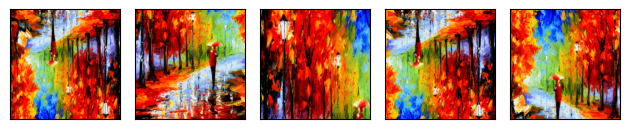

In [23]:
plot(images)

In [6]:
face_trans = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.7),
    # transforms.RandomVerticalFlip(p=0.4),
    # transforms.RandomRotation(),
    transforms.RandomApply(torch.nn.ModuleList([transforms.CenterCrop(size=0.8*512),]), p=0.7),
    # transforms.RandomResizedCrop(size=(512, 512), scale=[0.3, 1.0]),
    transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(kernel_size=(5,5)),]), p=0.7),
    # transforms.GaussianBlur(kernel_size=(5,5)),
    transforms.Resize((512, 512))
])

In [7]:
naugs = 50
for img_name in tqdm(os.listdir(face_path)):
    img = Image.open(os.path.join(
        face_path, img_name))
    images = [face_trans(img) for _ in range(naugs)]
    images = [transforms.functional.to_pil_image(img) for img in images]
    [img.save(os.path.join(save_face_path, img_name.split('.')[0], str(i)+'.jpg')) for i, img in enumerate(images)]

  0%|          | 0/3 [00:00<?, ?it/s]

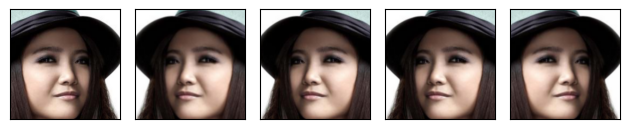

In [13]:
plot(images)